In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft,ifft
from scipy import signal
import soundfile as sf
import os, sys
import librosa
from scipy.fftpack import fft,dct

In [2]:
def load_files(folder_path):
    files = os.listdir(folder_path)
    normalized_list = []
    for file in files:
        file_path = os.path.join(folder_path, file)
        waveform, sr = librosa.load(file_path)
        normalized_waveform = waveform / np.max(np.abs(waveform))
        normalized_list.append(normalized_waveform)
    return normalized_list

In [3]:
test_car_path = r"C:\Users\fm728\audio_processing\project\test_car"
test_tram_path = r"C:\Users\fm728\audio_processing\project\test_tram"
train_car_path = r"C:\Users\fm728\audio_processing\project\train_car"
train_tram_path = r"C:\Users\fm728\audio_processing\project\train_tram"

sr = 22050

test_cars = load_files(test_car_path)
test_trams = load_files(test_tram_path)
train_cars = load_files(train_car_path)
train_trams = load_files(train_tram_path)

car1 = test_cars[0]
tram1 = test_trams[0]

In [4]:
epsilon = sys.float_info.epsilon # small positive value to avoid zeros inside the log
win_size = int(0.1*sr)           # window size
window = np.hamming(win_size)    # window function
hop_size = win_size//2           # hop size
n_fft=win_size       

def get_spectrogram(waveform):
    # Calculate amplitude spectrogram
    spec = np.abs(librosa.stft(waveform, n_fft=n_fft, hop_length=hop_size))
    # Convert to dB scale
    return librosa.amplitude_to_db(spec, ref=np.max)


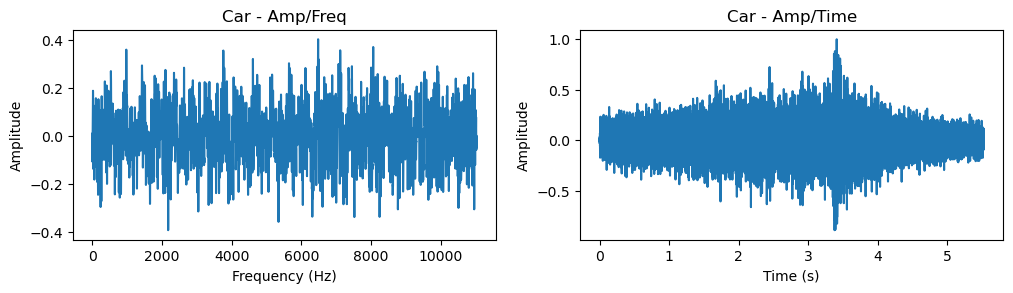

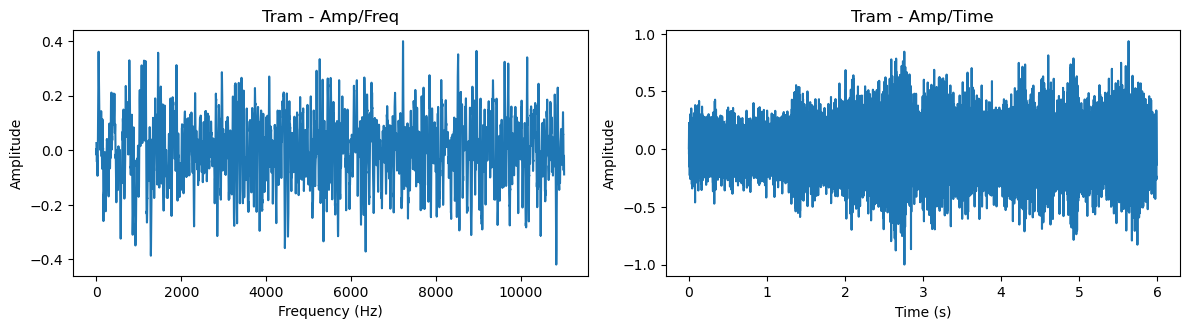

In [5]:

plt.figure(figsize=(12, 6))

# Car
# plot signals
plt.subplot(2, 2, 1)
plt.plot(car1[int(0.5*sr):int(1.0*sr)])
plt.title("Car - Amp/Freq")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")

plt.subplot(2, 2, 2)
time_axis_car1 = np.linspace(0, len(car1)/sr, len(car1), endpoint=False)
plt.plot(time_axis_car1, car1)
plt.title("Car - Amp/Time")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Tram
# plot signals
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 3)
plt.plot(tram1[int(0.5*sr):int(1.0*sr)])
plt.title("Tram - Amp/Freq")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")

plt.subplot(2, 2, 4)
time_axis_tram1 = np.linspace(0, len(tram1)/sr, len(tram1), endpoint=False)
plt.plot(time_axis_tram1, tram1)
plt.title("Tram - Amp/Time")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

In [6]:
# A function to plot spectrogram
def plot_spectrogram (s, spec, if_truncate=False):
    plt.imshow(spec,origin='lower',aspect='auto')
    locs, labels = plt.xticks()
    locs_=[np.round((i/locs[-1]*len(s)/sr),decimals=1) for i in locs]
    plt.xticks(locs[1:-1], locs_[1:-1])
    locs, labels = plt.yticks()
    if if_truncate:
      locs_=[int((i/locs[-1]*sr//16)) for i in locs]   # truncate the plot by a factor of 8
    else:
      locs_=[int((i/locs[-1]*sr//2)) for i in locs]
    plt.yticks(locs[1:-1], locs_[1:-1])
    plt.colorbar()
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

In [7]:
pre_emphasis = 0.97

def get_power_spectrogram(s):
    time_axis = np.linspace(0, len(s)/sr, len(s), endpoint=False)
#   s_ = np.append(s[0], s[1:] - pre_emphasis * s[:-1])
    n_frames =int((len(s)-win_size)/hop_size)+1  
    power_spectrogram = np.zeros((n_fft//2+1,n_frames),dtype=np.float32)
    mfccs = np.zeros((40,n_frames),dtype=np.float32)

    for i in np.arange(0, n_frames):
        s_seg = s[i*hop_size:i*hop_size+win_size]      # audio frame
#        s_seg = s_[i*hop_size:i*hop_size+win_size]
        s_win_seg = window * s_seg  # Window each frame using hamming window    
        spectrum  = fft(s_win_seg,n_fft) # Calculate fft
        spectrum = spectrum[:n_fft//2+1] 
        power_spectrum = np.power(np.abs(spectrum),2) # Collect the power spectrum
        power_spectrogram[:,i] = power_spectrum   
        
    return power_spectrogram


Text(0.5, 1.0, 'Tram - Logrithmic power spectrogram')

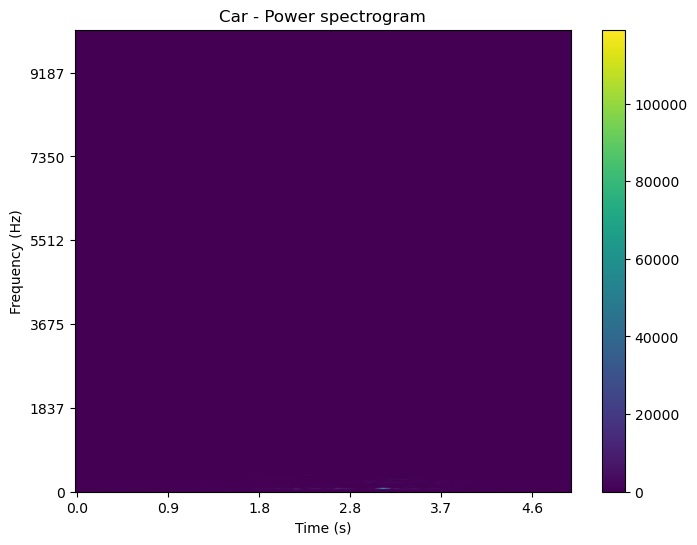

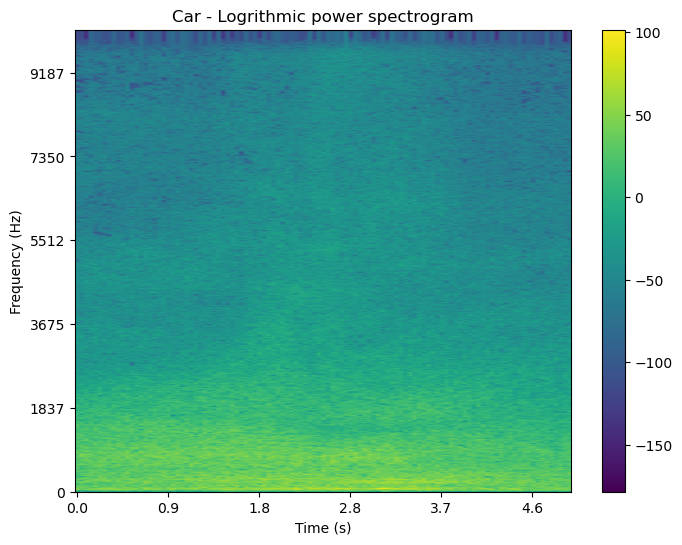

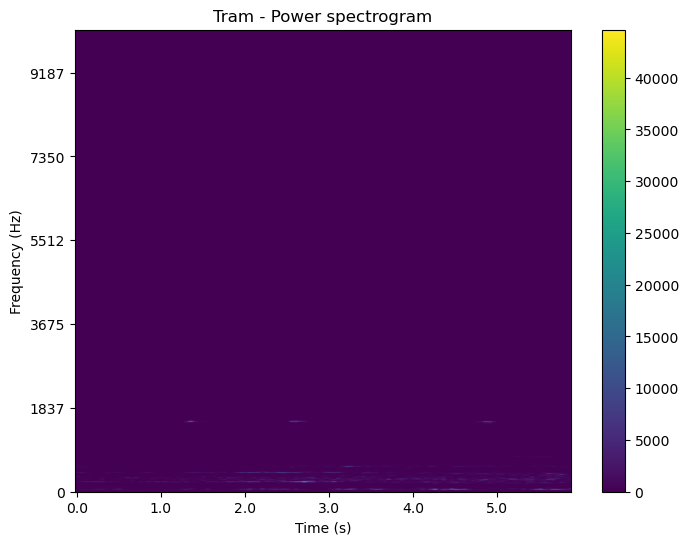

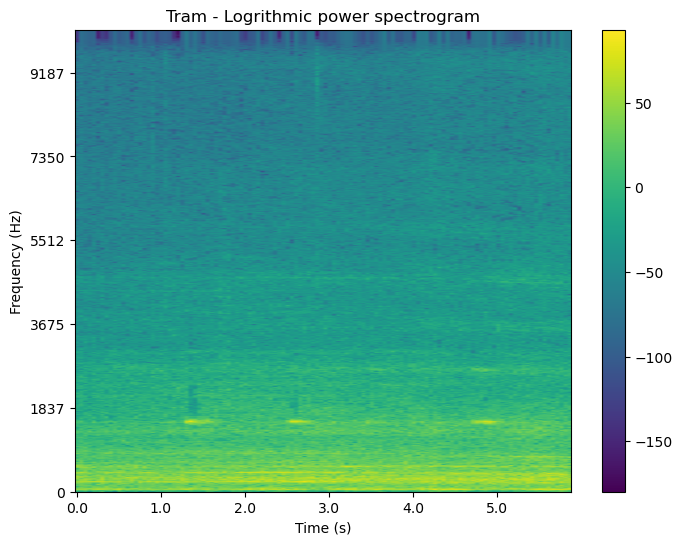

In [8]:
# Plot the power spectrogram

# plt.figure(figsize=(12, 6))
car_power_spectro = get_power_spectrogram(car1)
# plt.subplot(2, 2, 1)
plt.figure(figsize=(8, 6))
plot_spectrogram(car1, car_power_spectro)
plt.title('Car - Power spectrogram')

car_log_power_spectro = 20 * np.log10(car_power_spectro)
# plt.subplot(2, 2, 2)
plt.figure(figsize=(8, 6))
plot_spectrogram(car1, car_log_power_spectro)
plt.title('Car - Logrithmic power spectrogram')

tram_power_spectro = get_power_spectrogram(tram1)
# plt.subplot(2, 2, 3)
plt.figure(figsize=(8, 6))
plot_spectrogram(tram1, tram_power_spectro)
plt.title('Tram - Power spectrogram')

tram_log_power_spectro = 20 * np.log10(tram_power_spectro)
# plt.subplot(2, 2, 4)
plt.figure(figsize=(8, 6))
plot_spectrogram(tram1, tram_log_power_spectro)
plt.title('Tram - Logrithmic power spectrogram')

In [9]:
n_mel = 40
mel_filterbank = librosa.filters.mel(sr=sr,n_fft=n_fft,n_mels=n_mel)

In [10]:
car_mel_spectro = np.dot(mel_filterbank, car_power_spectro)
tram_mel_spectro = np.dot(mel_filterbank, tram_power_spectro)

car_log_mel_spectrum = 20 * np.log10(car_mel_spectro+1e-12)
tram_log_mel_spectrum = 20 * np.log10(tram_mel_spectro+1e-12)

car_mfcc = dct(car_log_mel_spectrum, axis=0)
tram_mfcc = dct(tram_log_mel_spectrum, axis=0)

Text(0.5, 1.0, 'MFCC')

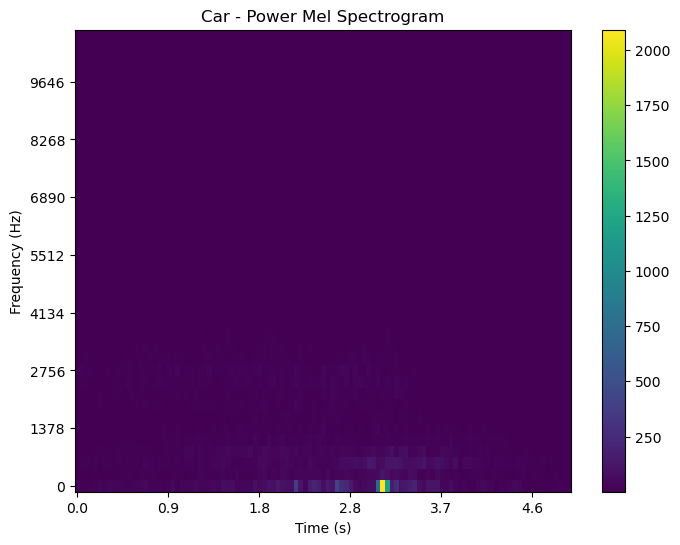

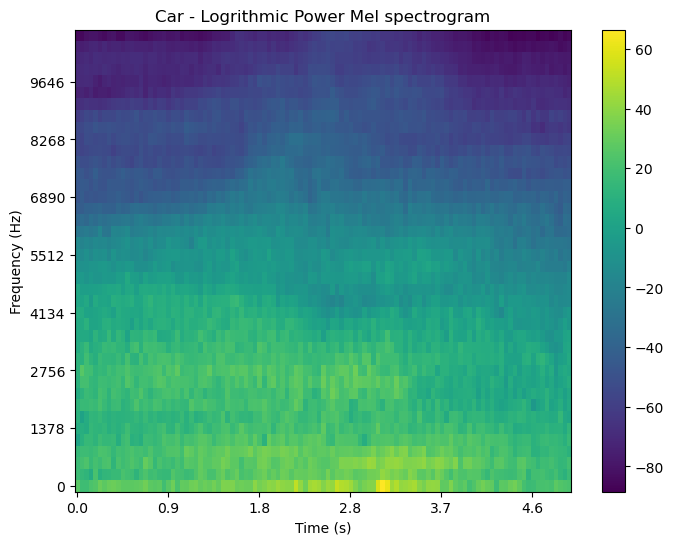

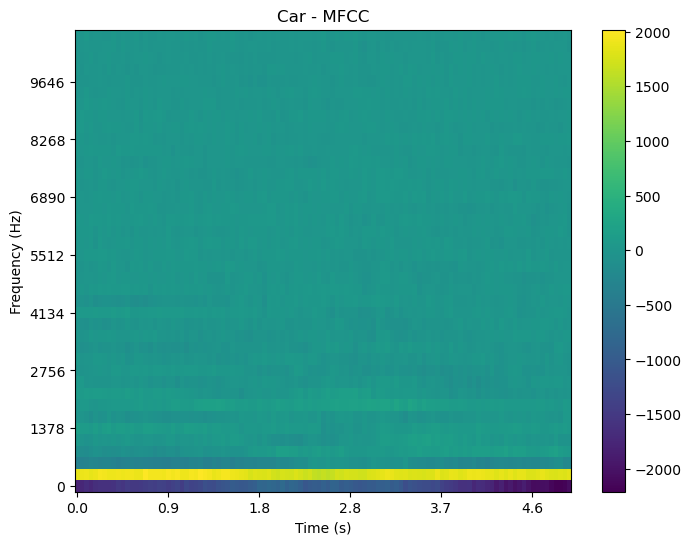

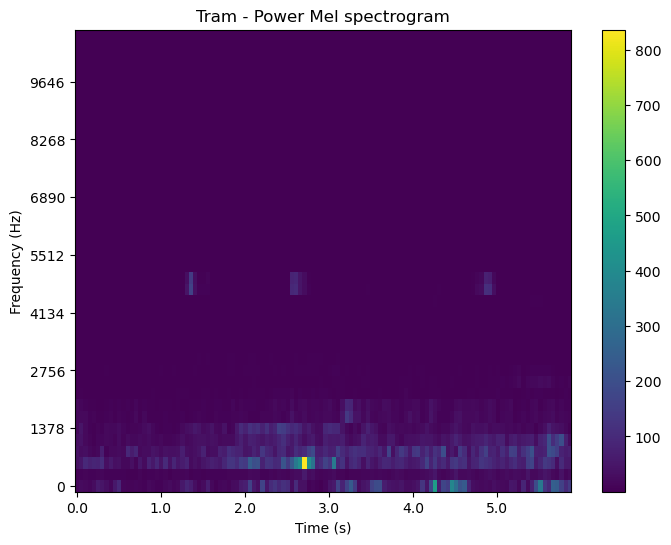

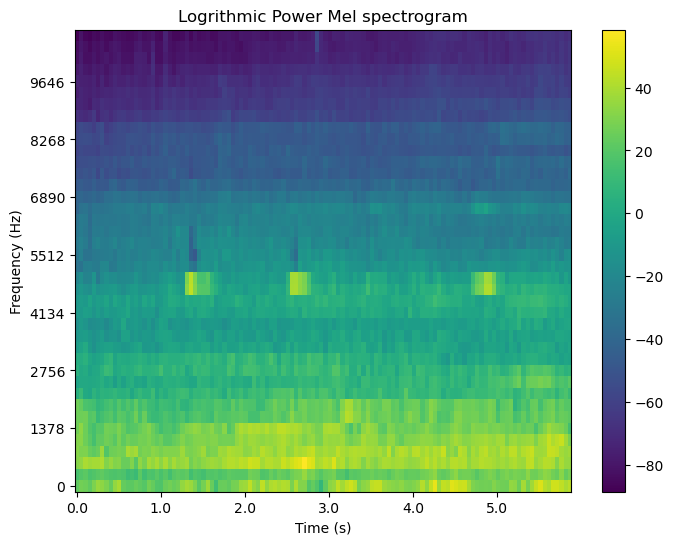

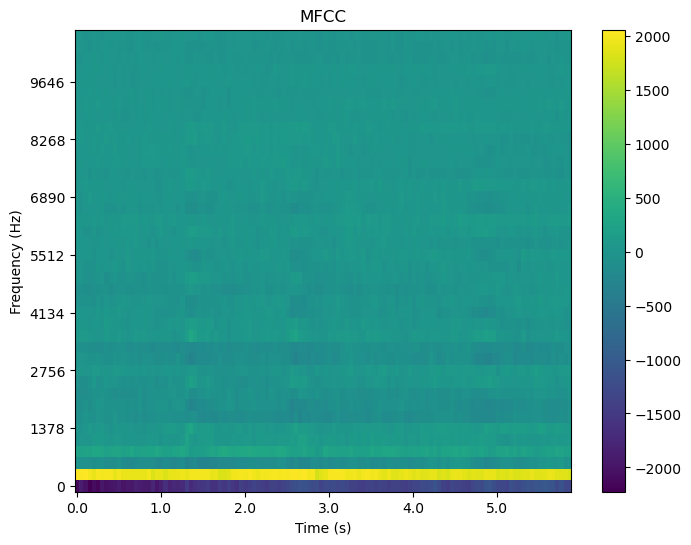

In [11]:
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 3, 1)
plt.figure(figsize=(8, 6))
plot_spectrogram(car1, car_mel_spectro)
plt.title('Car - Power Mel Spectrogram')

# plt.subplot(2, 3, 2)
plt.figure(figsize=(8, 6))
plot_spectrogram(car1, car_log_mel_spectrum)
plt.title('Car - Logrithmic Power Mel spectrogram')

# plt.subplot(2, 3, 3)
plt.figure(figsize=(8, 6))
plot_spectrogram(car1, car_mfcc)
plt.title('Car - MFCC')

# plt.subplot(2, 3, 4)
plt.figure(figsize=(8, 6))
plot_spectrogram(tram1, tram_mel_spectro)
plt.title('Tram - Power Mel spectrogram')

# plt.subplot(2, 3, 5)
plt.figure(figsize=(8, 6))
plot_spectrogram(tram1, tram_log_mel_spectrum)
plt.title('Logrithmic Power Mel spectrogram')

# plt.subplot(2, 3, 6)
plt.figure(figsize=(8, 6))
plot_spectrogram(tram1, tram_mfcc)
plt.title('MFCC')

In [87]:
def plot_histograms(data, labels, feature_name, num):
    plt.figure(figsize=(10, 6))
#     plt.subplot(3, 2, num)
    
    all_data_flat = [item for sublist in [sample.flatten() for sample in data] for item in sublist]
    for label in set(labels):
        class_data = [item for sublist in [sample.flatten() for sample, label_ in zip(data, labels) if label_ == label] for item in sublist]
        plt.hist(class_data, bins=50, alpha=0.5, label=f'Class {label}', density=True, stacked=True)
    # print(np.max(all_data_flat))
    plt.xlim(np.min(all_data_flat), np.max(all_data_flat))
    plt.legend()
    plt.title(f'Histograms of {feature_name}')
    


119007.04
101.51145
2092.0503
66.411446
2056.7053


Text(0, 0.5, 'Density')

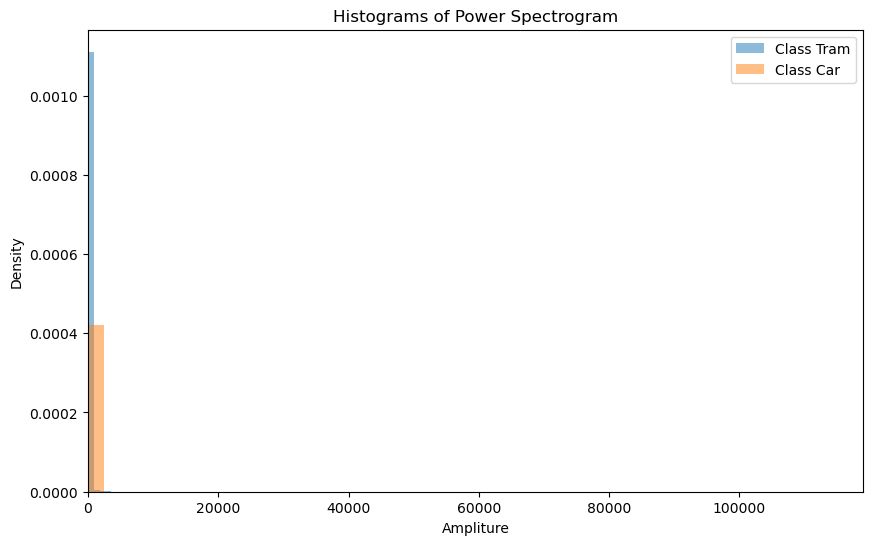

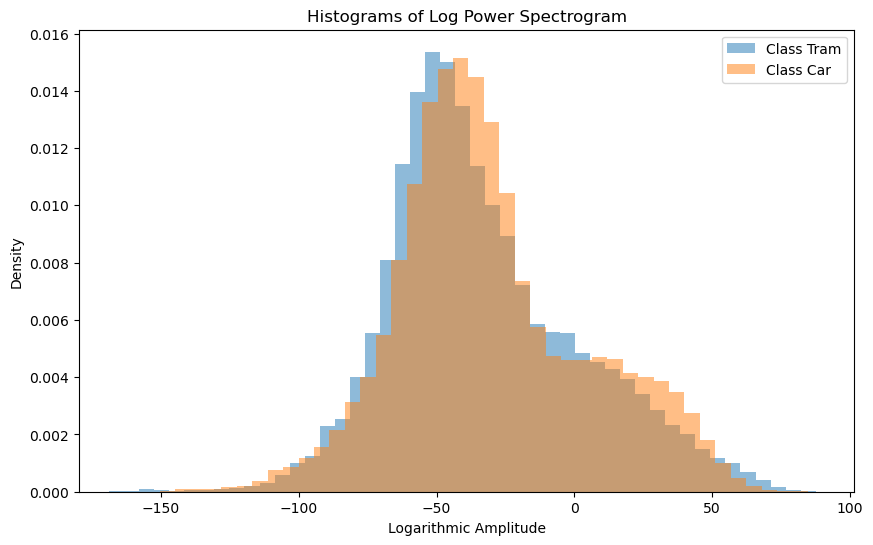

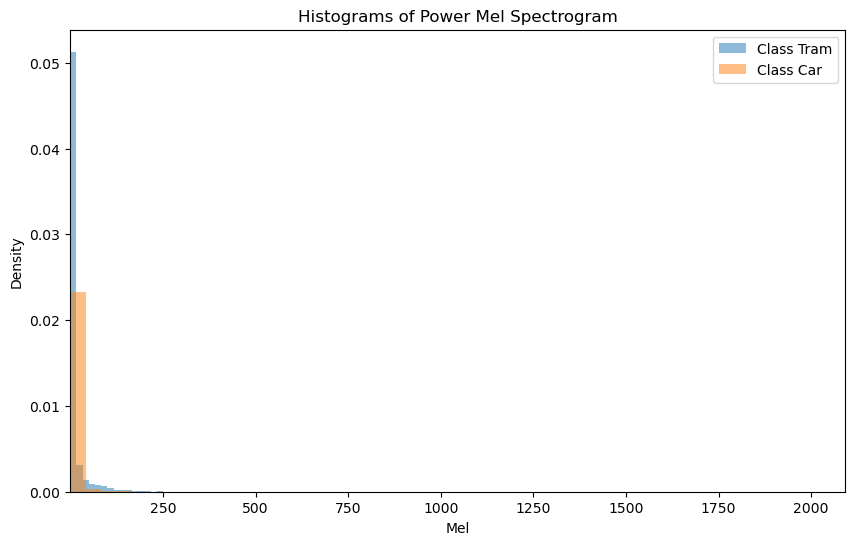

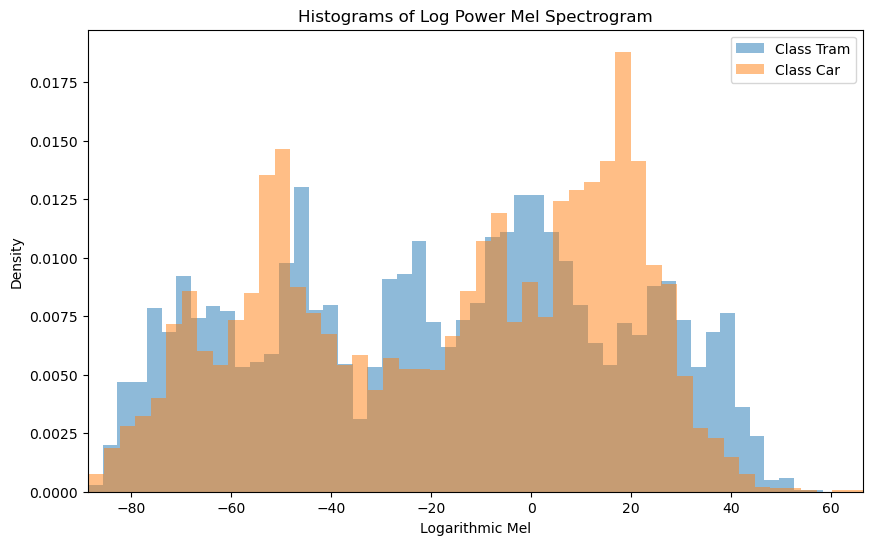

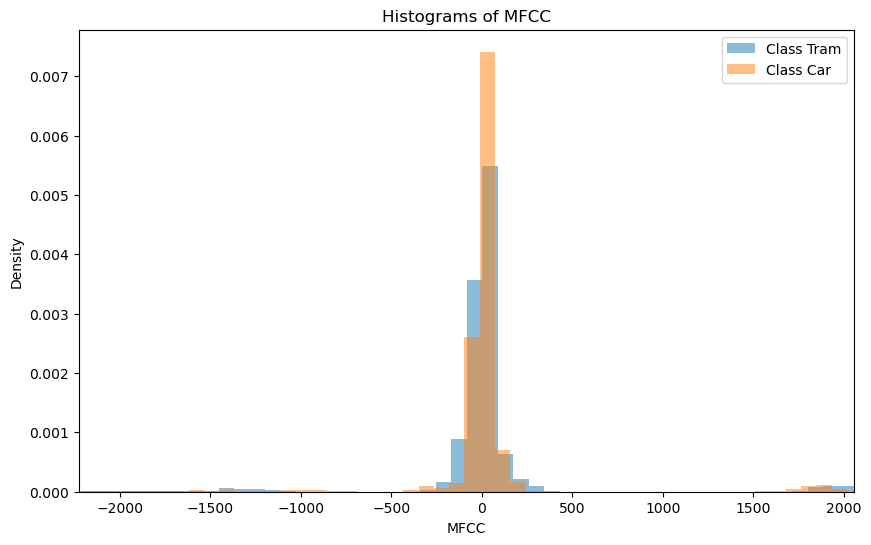

In [88]:
num_samples = 5

# Get features
car_spec_features = [car_power_spectro for s in test_cars[:num_samples]]
tram_spec_features = [tram_power_spectro for s in test_trams[:num_samples]]

car_log_spec_features = [car_log_power_spectro for s in test_cars[:num_samples]]
tram_log_spec_features = [tram_log_power_spectro for s in test_trams[:num_samples]]

car_mel_features = [car_mel_spectro for s in test_cars[:num_samples]]
tram_mel_features = [tram_mel_spectro for s in test_trams[:num_samples]]

car_log_mel_features = [car_log_mel_spectrum for s in test_cars[:num_samples]]
tram_log_mel_features = [tram_log_mel_spectrum for s in test_trams[:num_samples]]

car_mfcc_features = [car_mfcc for s in test_cars[:num_samples]]
tram_mfcc_features = [tram_mfcc for s in test_trams[:num_samples]]


# Plot histgrams
plot_histograms(car_spec_features + tram_spec_features, 
                labels=['Car']*num_samples + ['Tram']*num_samples, 
                feature_name='Power Spectrogram', num=1)
plt.xlabel('Ampliture')
plt.ylabel('Density')
    
plot_histograms(car_log_spec_features + tram_log_spec_features, 
                labels=['Car']*num_samples + ['Tram']*num_samples, 
                feature_name='Log Power Spectrogram', num=2)
plt.xlabel('Logarithmic Amplitude')
plt.ylabel('Density')

plot_histograms(car_mel_features + tram_mel_features, 
                labels=['Car']*num_samples + ['Tram']*num_samples, 
                feature_name='Power Mel Spectrogram', num=3)
plt.xlabel('Mel')
plt.ylabel('Density')
    
plot_histograms(car_log_mel_features + tram_log_mel_features, 
                labels=['Car']*num_samples + ['Tram']*num_samples, 
                feature_name='Log Power Mel Spectrogram', num=4)
plt.xlabel('Logarithmic Mel')
plt.ylabel('Density')

plot_histograms(car_mfcc_features + tram_mfcc_features, 
                labels=['Car']*num_samples + ['Tram']*num_samples, 
                feature_name='MFCC', num=5)
plt.xlabel('MFCC')
plt.ylabel('Density')

In [84]:
def get_log_mel_spectrum(s):
    s_ = np.append(s[0], s[1:] - pre_emphasis * s[:-1])
    n_frames = int((len(s)-win_size)/hop_size)+1   
    mfccs = np.zeros((40,n_frames),dtype=np.float32)
    power_spectro = np.zeros((n_fft//2+1,n_frames),dtype=np.float32) 

    for i in np.arange(0,n_frames):   
        s_seg = s_[i*hop_size:i*hop_size+win_size]
        s_win_seg = window * s_seg  # Window each frame using hamming window    
        spectrum  = fft(s_win_seg,n_fft) # Calculate fft
        spectrum = spectrum[:n_fft//2+1] 
        power_spectrum = np.power(np.abs(spectrum),2) # Collect the power spectrum
        power_spectro[:,i] = power_spectrum
        
    mel_spectro= np.dot(mel_filterbank, power_spectro) # Multiply it with the mel filterbank 
    log_mel_spectrum = 20 * np.log10(mel_spectro+1e-12) # Take log operation

    return log_mel_spectrum

In [25]:
log_mel_test_cars = []
log_mel_test_trams = []
log_mel_train_cars = []
log_mel_train_trams = []


for s in test_cars:
    log_mel_test_cars.append(get_log_mel_spectrum(s))    

for s in test_trams:
    log_mel_test_trams.append(get_log_mel_spectrum(s))

for s in train_cars:
    log_mel_train_cars.append(get_log_mel_spectrum(s))    

for s in train_trams:
    log_mel_train_trams.append(get_log_mel_spectrum(s))


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [27]:
# Preprocessing of training and validation 
max_length = max(len(spectrogram.flatten()) 
                 for spectrogram in log_mel_train_cars + log_mel_train_trams)
X = np.array([np.pad(spectrogram.flatten(), (0, max_length - len(spectrogram.flatten()))) 
              for spectrogram in log_mel_train_cars + log_mel_train_trams])
y = np.array([0] * len(log_mel_train_cars) + [1] * len(log_mel_train_trams))

# Split ad training and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the model
model = LogisticRegression()
model.fit(X_train, y_train)

# evaluate the model with validation data
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9762


In [28]:
# Preprocessing of testing data 
X_test = np.array([np.pad(spectrogram.flatten(), (0, max_length - len(spectrogram.flatten()))) 
                   for spectrogram in log_mel_test_cars + log_mel_test_trams])
y_test = np.array([0] * len(log_mel_test_cars) + [1] * len(log_mel_test_trams))

# evaluate the model with testing data
y_pred_test = model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {accuracy_test:.4f}")

Test Accuracy: 0.9545
